In [64]:
# New York City Taxi and Limousine Commission trip records
# Use Green Taxis December 2016 data
# Analyze the data, find useful statistics and build a model to predict which type of trips yield most tips

# Data dictionary for green taxis has been used for code-name mapping for some fields (RateCodeID, Payment_type)
    # https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf

# install the following packages - pandas, numpy, scikit-learn, xgboost, matplotlib, seaborn, pyarrow
# import the libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings('ignore')
import pyarrow.parquet as pq

# load green taxi Dec '16 data
# Load this data from https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2016-12.parquet
tripdata = pq.read_table('./green_tripdata_2016-12.parquet')
tripdata = tripdata.to_pandas()

# Load the zone code table
# Load this data from https://s3.amazonaws.com/nyc-tlc/misc/taxi+_zone_lookup.csv
loc_zone = pd.read_csv('./taxi+_zone_lookup.csv')

In [65]:
# 1. Characterizing the data, size, types and quality

In [66]:
# Using info() we can see the different fields, types, size and non-null count
# There are 1224158 rows and 20 columns of data
# Most fields are numeric (int, float), 2 datetime and 3 objects
# Two object fields 'ehail_fee' and 'congestion_surcharge' are completely null. Possibly not entered during data capture
print(tripdata.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1224158 entries, 0 to 1224157
Data columns (total 20 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   VendorID               1224158 non-null  int64         
 1   lpep_pickup_datetime   1224158 non-null  datetime64[ns]
 2   lpep_dropoff_datetime  1224158 non-null  datetime64[ns]
 3   store_and_fwd_flag     1224158 non-null  object        
 4   RatecodeID             1224158 non-null  int64         
 5   PULocationID           1224158 non-null  int64         
 6   DOLocationID           1224158 non-null  int64         
 7   passenger_count        1224158 non-null  int64         
 8   trip_distance          1224158 non-null  float64       
 9   fare_amount            1224158 non-null  float64       
 10  extra                  1224158 non-null  float64       
 11  mta_tax                1224158 non-null  float64       
 12  tip_amount             12241

In [67]:
# Using head() we can get some idea of the data content 
# The data quality looks good and clean with only 2 object fields containing 'None'
# They can possibly be dropped from the dataset as they have no use during model building
print(tripdata.head())

   VendorID lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
0         2  2016-12-01 00:13:25   2016-12-01 00:25:41                  N   
1         2  2016-12-01 00:06:47   2016-12-01 00:08:52                  N   
2         1  2016-12-01 00:29:45   2016-12-01 00:34:21                  N   
3         1  2016-12-01 00:05:43   2016-12-01 00:11:56                  N   
4         1  2016-12-01 00:47:13   2016-12-01 01:02:59                  N   

   RatecodeID  PULocationID  DOLocationID  passenger_count  trip_distance  \
0           1           225            65                1           2.79   
1           1           255           255                1           0.45   
2           1            41            42                1           1.20   
3           1            80           255                1           1.40   
4           1           255           189                1           3.50   

   fare_amount  extra  mta_tax  tip_amount  tolls_amount ehail_fee  \
0   

In [68]:
# Using describe() we can see some summary descriptive statistics about the different fields
# Data looks skewed as std dev is quite large relative to mean for some amount fields
# Some amount fields have -ve min amount, indicating possible refund
print(tripdata.describe())

           VendorID    RatecodeID  PULocationID  DOLocationID  \
count  1.224158e+06  1.224158e+06  1.224158e+06  1.224158e+06   
mean   1.799278e+00  1.085079e+00  1.131729e+02  1.290862e+02   
std    4.005404e-01  5.660195e-01  7.628387e+01  7.723367e+01   
min    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
25%    2.000000e+00  1.000000e+00  4.900000e+01  6.100000e+01   
50%    2.000000e+00  1.000000e+00  8.300000e+01  1.290000e+02   
75%    2.000000e+00  1.000000e+00  1.730000e+02  1.930000e+02   
max    2.000000e+00  6.000000e+00  2.650000e+02  2.650000e+02   

       passenger_count  trip_distance   fare_amount         extra  \
count     1.224158e+06   1.224158e+06  1.224158e+06  1.224158e+06   
mean      1.362447e+00   2.618179e+00  1.159368e+01  3.629562e-01   
std       1.036924e+00   2.806160e+00  9.793499e+00  3.901575e-01   
min       0.000000e+00   0.000000e+00 -4.990000e+02 -4.500000e+00   
25%       1.000000e+00   9.800000e-01  6.000000e+00  0.000000e+00   


In [69]:
# 2. Perform EDA to explore and visualize the data. Do data wrangling as required

In [70]:
# On checking 2 -ve amount fields, we can see their payment_type can be any type
# This is fine for regression models as they can handle both +ve and -ve values
print(tripdata.loc[tripdata['total_amount']<0, ['total_amount','payment_type']].head())
print(tripdata.loc[tripdata['tip_amount']<0, ['tip_amount','payment_type']].head())

      total_amount  payment_type
378           -3.8             2
1404         -52.8             4
1817          -4.3             4
1983         -60.0             3
2319          -4.3             3
        tip_amount  payment_type
4778         -1.00             3
57767        -0.99             3
112731       -3.25             3
180092       -1.06             3
211462      -10.56             1


In [71]:
# Check for null/NaN data, to make sure which columns can be dropped if too many null values
print(tripdata.isnull().sum())

VendorID                       0
lpep_pickup_datetime           0
lpep_dropoff_datetime          0
store_and_fwd_flag             0
RatecodeID                     0
PULocationID                   0
DOLocationID                   0
passenger_count                0
trip_distance                  0
fare_amount                    0
extra                          0
mta_tax                        0
tip_amount                     0
tolls_amount                   0
ehail_fee                1224158
improvement_surcharge          0
total_amount                   0
payment_type                   0
trip_type                      0
congestion_surcharge     1224158
dtype: int64


In [72]:
# Two object fields 'ehail_fee' and 'congestion_surcharge' are completely null so we will drop them
tripdata.drop(['ehail_fee','congestion_surcharge'], axis=1, inplace=True)

In [73]:
# For the remaining object field, 'store_and_fwd_flag', check its type and content
# It is a binary field with Y and N values
print(tripdata['store_and_fwd_flag'].value_counts())

N    1222074
Y       2084
Name: store_and_fwd_flag, dtype: int64


In [74]:
# store_and_fwd_flag needs to be encoded to numeric values, so that it can be used for model building 
# Using OneHotEncoder for encoding and handling dummy variable/correlation issue in new replacement columns 
tripdata_cat = np.array(tripdata['store_and_fwd_flag']).reshape(-1,1)
tripdata.drop(['store_and_fwd_flag'], axis=1, inplace=True)

ohe = OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse=False)
tripdata_cat = pd.DataFrame(ohe.fit_transform(tripdata_cat), columns=['store_and_fwd_flag'])

# View the new encoded categorical field
print(tripdata_cat.value_counts())

store_and_fwd_flag
0.0                   1222074
1.0                      2084
dtype: int64


In [75]:
# Add the encoded field back to the original dataset, as we have removed the origical categorical field
tripdata = tripdata.join(tripdata_cat)
print(tripdata.head())

   VendorID lpep_pickup_datetime lpep_dropoff_datetime  RatecodeID  \
0         2  2016-12-01 00:13:25   2016-12-01 00:25:41           1   
1         2  2016-12-01 00:06:47   2016-12-01 00:08:52           1   
2         1  2016-12-01 00:29:45   2016-12-01 00:34:21           1   
3         1  2016-12-01 00:05:43   2016-12-01 00:11:56           1   
4         1  2016-12-01 00:47:13   2016-12-01 01:02:59           1   

   PULocationID  DOLocationID  passenger_count  trip_distance  fare_amount  \
0           225            65                1           2.79         11.0   
1           255           255                1           0.45          3.5   
2            41            42                1           1.20          6.0   
3            80           255                1           1.40          6.5   
4           255           189                1           3.50         13.5   

   extra  mta_tax  tip_amount  tolls_amount  improvement_surcharge  \
0    0.5      0.5        0.00           

In [76]:
# We can use the 2 datetime fields 'lpep_pickup_datetime' and 'lpep_dropoff_datetime' for model building
# By extracting/calculating fields like - hour, day, weekday, trip duration. These will be more useful
# Weekday code: Monday=0, Sunday=6
tripdata['weekday'] = tripdata['lpep_pickup_datetime'].dt.weekday
tripdata['day'] = tripdata['lpep_pickup_datetime'].dt.day
tripdata['hour'] = tripdata['lpep_pickup_datetime'].dt.hour
tripdata['duration_mins'] = (tripdata['lpep_dropoff_datetime'] - tripdata['lpep_pickup_datetime']).dt.total_seconds().div(60)
tripdata.drop(['lpep_pickup_datetime','lpep_dropoff_datetime'], axis=1, inplace=True)
print(tripdata.head())

   VendorID  RatecodeID  PULocationID  DOLocationID  passenger_count  \
0         2           1           225            65                1   
1         2           1           255           255                1   
2         1           1            41            42                1   
3         1           1            80           255                1   
4         1           1           255           189                1   

   trip_distance  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0           2.79         11.0    0.5      0.5        0.00           0.0   
1           0.45          3.5    0.5      0.5        0.96           0.0   
2           1.20          6.0    0.5      0.5        0.00           0.0   
3           1.40          6.5    0.5      0.5        0.00           0.0   
4           3.50         13.5    0.5      0.5        3.70           0.0   

   improvement_surcharge  total_amount  payment_type  trip_type  \
0                    0.3         12.30           

147.5 0.0 2.6181790994299323


<AxesSubplot:xlabel='trip_distance', ylabel='Count'>

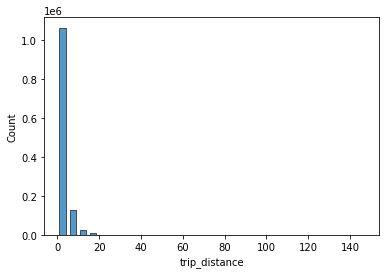

In [77]:
# Do visualization using histograms - trip_distance, amount and passenger fields are shown
# This will tell us about their data distribtuion and skewness
# We can see that it is skewed in most cases majority of data is concentrated around mean
# Histogram plots contain count distribution
print(tripdata['trip_distance'].max(), tripdata['trip_distance'].min(), tripdata['trip_distance'].mean())
sns.histplot(data=tripdata['trip_distance'], shrink=.6, bins=30)
plt.show()

1008.3 -499.0 13.999016949014056


<AxesSubplot:xlabel='total_amount', ylabel='Count'>

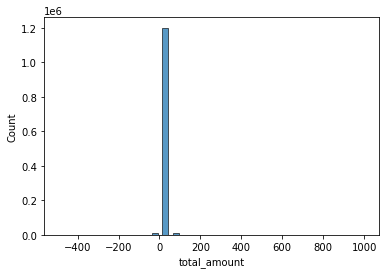

In [78]:
print(tripdata['total_amount'].max(), tripdata['total_amount'].min(), tripdata['total_amount'].mean())
sns.histplot(data=tripdata['total_amount'], shrink=.6, bins=30)
plt.show()

250.7 -10.56 1.1287872317134355


<AxesSubplot:xlabel='tip_amount', ylabel='Count'>

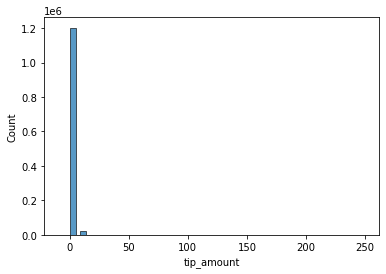

In [79]:
print(tripdata['tip_amount'].max(), tripdata['tip_amount'].min(), tripdata['tip_amount'].mean())
sns.histplot(data=tripdata['tip_amount'], shrink=.6, bins=30)
plt.show()

9 0 1.3624466776347497


<AxesSubplot:xlabel='passenger_count', ylabel='Count'>

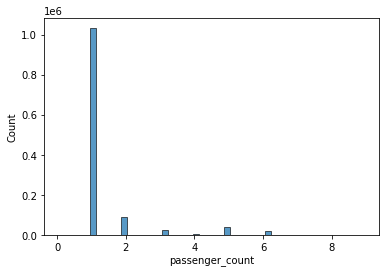

In [80]:
print(tripdata['passenger_count'].max(), tripdata['passenger_count'].min(), tripdata['passenger_count'].mean())
sns.histplot(data=tripdata['passenger_count'], shrink=.6, bins=30)
plt.show()

<AxesSubplot:>

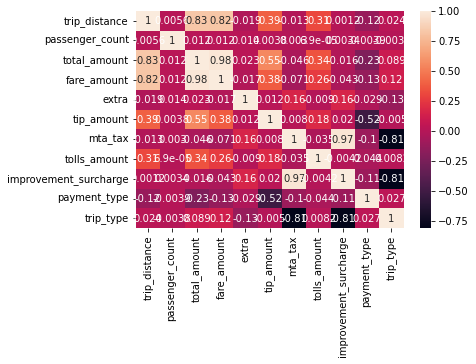

In [81]:
# Check the correlation between some relevant fields, to determine if they can be dropped before model building
# As there are a lot of different component amount fields its possible they are highly correlated to total_amount
# 'fare_amount' and 'trip_distance' are highly correlated with 'total_amount'
# We can possibly drop fare_amount during model building as that is a component of total_amount
# But trip_distance might be useful to keep being a non-amount field
trip_corrdata = tripdata[['trip_distance','passenger_count', 'total_amount','fare_amount','extra','tip_amount', 'mta_tax', 'tolls_amount','improvement_surcharge','payment_type', 'trip_type']]
sns.heatmap(trip_corrdata.corr(),square=False, annot=True)
plt.show()

In [82]:
# 3. Find interesting trip statistics grouped by hour 

# We can see statistics like sum, mean std dev, etc once data is grouped
# The ouptut is shown for some relevant fields with different sorting like trip_distance and tip_amount

In [83]:
# Showing sum statistic first, which gives month total by hour for different amount, distance and passenger count fields
# Evening and night hour times have the highest values for trip_distance, indicating more trips at night
# While useful, its probably not the best statistic as we are more interested in trip level statistic. Mean is a better measure
print(tripdata.loc[:,['trip_distance','passenger_count', 'total_amount','fare_amount','extra','tip_amount','hour']].groupby(['hour']).sum().sort_values(['trip_distance'],ascending=False))

      trip_distance  passenger_count  total_amount  fare_amount     extra  \
hour                                                                        
19        202849.71           119948    1162096.27    932205.12  59805.50   
18        201027.09           119682    1199030.81    965432.76  60854.00   
17        192133.90           109772    1167594.36    949239.13  55995.22   
20        189980.78           108261    1028942.73    838639.58  38856.00   
21        185915.90           101297     974210.44    795108.10  35696.00   
22        180159.29            93591     922177.72    752987.84  33027.50   
16        175019.89            95515    1038642.59    850075.03  46800.50   
15        166148.34            87903     923606.61    791534.99   2009.50   
23        164832.19            82962     826765.31    676055.36  29359.00   
14        147510.79            76587     795787.72    683096.69    259.00   
0         137124.92            67739     680290.85    555189.91  23810.50   

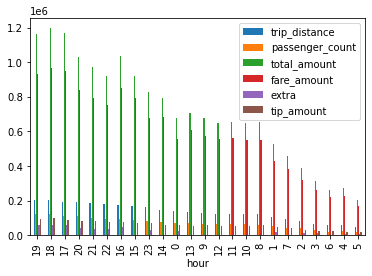

In [84]:
# Visual plot is better to see grouped data
tripdata.loc[:,['trip_distance','passenger_count', 'total_amount','fare_amount','extra','tip_amount','hour']].groupby(['hour']).sum().sort_values(['trip_distance'],ascending=False).plot(kind='bar').legend(loc='upper right')

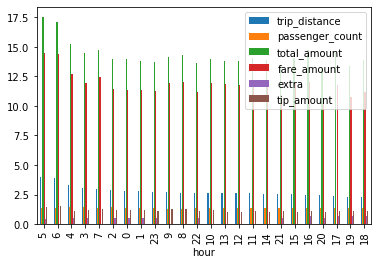

In [85]:
# Using mean and std dev as they are better measure for trip level statistics
# trip_distance - Mean values show that trip_distance is highest in the morning hours, indicating longer trips
tripdata.loc[:,['trip_distance','passenger_count', 'total_amount','fare_amount','extra','tip_amount','hour']].groupby(['hour']).mean().sort_values(['trip_distance'],ascending=False).plot(kind='bar').legend(loc='upper right')

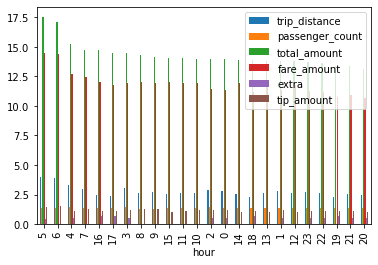

In [86]:
# total_amount - Mean values show that total_amount is generally higher in the morning hours, due to longer trips higer fare
tripdata.loc[:,['trip_distance','passenger_count', 'total_amount','fare_amount','extra','tip_amount','hour']].groupby(['hour']).mean().sort_values(['total_amount'],ascending=False).plot(kind='bar').legend(loc='upper right')

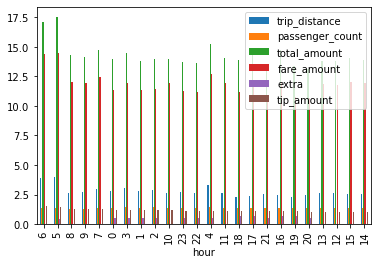

In [87]:
# Sorting by tip_amount going forward as that is the output prediction from the model we are interested in
# tip_amount - Mean values show that tip_amount is highest in the morning hours, due to longer higher fare trip
tripdata.loc[:,['trip_distance','passenger_count', 'total_amount','fare_amount','extra','tip_amount','hour']].groupby(['hour']).mean().sort_values(['tip_amount'],ascending=False).plot(kind='bar').legend(loc='upper right')

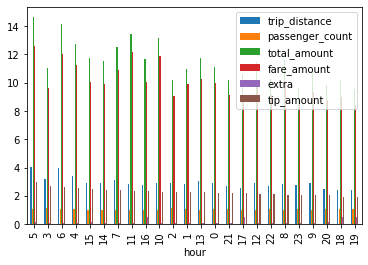

In [88]:
# tip_amount - Std dev values show no clear pattern by hour, so will not analyse them
tripdata.loc[:,['trip_distance','passenger_count', 'total_amount','fare_amount','extra','tip_amount','hour']].groupby(['hour']).std().sort_values(['tip_amount'],ascending=False).plot(kind='bar').legend(loc='upper right')

In [89]:
# Doing some other groupings to see what other useful analysis can be done on different features

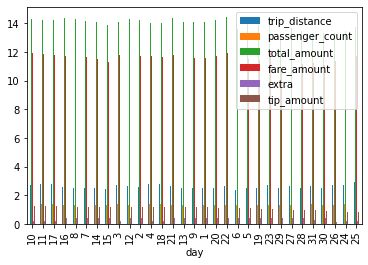

In [90]:
# Groupby day - Mean values show very similar results by day
tripdata.loc[:,['trip_distance','passenger_count', 'total_amount','fare_amount','extra','tip_amount','day']].groupby(['day']).mean().sort_values(['tip_amount'],ascending=False).plot(kind='bar').legend(loc='upper right')

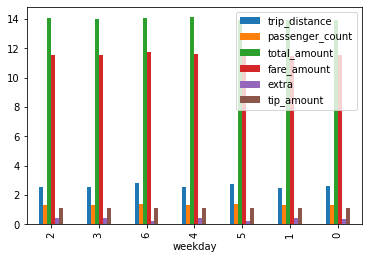

In [91]:
#  Groupby weekday - Mean values show very similar results by weekday
tripdata.loc[:,['trip_distance','passenger_count', 'total_amount','fare_amount','extra','tip_amount','weekday']].groupby(['weekday']).mean().sort_values(['tip_amount'],ascending=False).plot(kind='bar').legend(loc='upper right')

<AxesSubplot:xlabel='trip_type'>

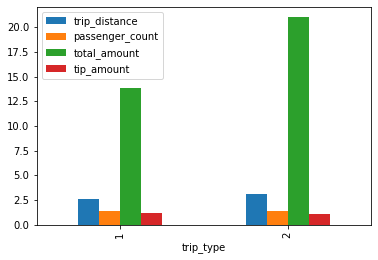

In [92]:
#  Groupby trip_type - Mean values show type=2 (Dispatch) has higher values
tripdata.loc[:,['trip_type','trip_distance','passenger_count', 'total_amount', 'tip_amount']].groupby(['trip_type']).mean().sort_values(['tip_amount'],ascending=False).plot(kind='bar')

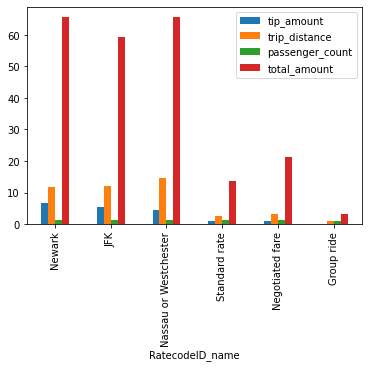

In [93]:
# RatecodeID is mapped to name using Data dictionary
# Groupby Ratecodename - mean values show that 'Newark' has highest tip and total amount. Others are self explanatory
RatecodeID_data = tripdata.loc[:,['tip_amount','trip_distance','passenger_count', 'total_amount', 'RatecodeID']].groupby(['RatecodeID']).mean().sort_values(['tip_amount'],ascending=False)
RatecodeID_name = pd.DataFrame(list([[1,'Standard rate'],[2,'JFK'],[3,'Newark'],[4,'Nassau or Westchester'],[5,'Negotiated fare'],[6,'Group ride']]),columns=['RatecodeID','RatecodeID_name'])
Ratecodename = pd.merge(RatecodeID_data,RatecodeID_name,how='inner',on='RatecodeID')
Ratecodename.index = Ratecodename['RatecodeID_name']
Ratecodename.drop(['RatecodeID','RatecodeID_name'],axis=1,inplace=True)
Ratecodename.plot(kind='bar').legend(loc='upper right')

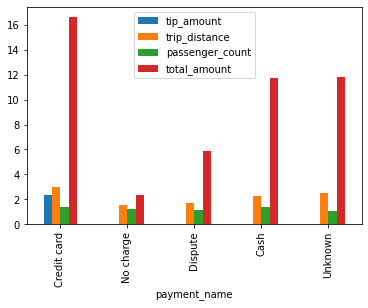

In [94]:
# Groupby pmt_typename - mean values show that only 'Credit card' has tip_amount and highest total_amount
# 'cash' and 'unknown' tips are 0 with 2nd highest total amount. This is useful to know for model training data
pmt_type = tripdata.loc[:,['tip_amount','trip_distance','passenger_count', 'total_amount', 'payment_type']].groupby(['payment_type']).mean().sort_values(['tip_amount'],ascending=False)
pmt_name = pd.DataFrame(list([[1,'Credit card'],[2,'Cash'],[3,'No charge'],[4,'Dispute'],[5,'Unknown'],[6,'Voided trip']]),columns=['payment_type','payment_name'])
pmt_typename = pd.merge(pmt_type,pmt_name,how='inner',on='payment_type')
pmt_typename.index = pmt_typename['payment_name']
pmt_typename.drop(['payment_type','payment_name'],axis=1,inplace=True)
pmt_typename.plot(kind='bar').legend(loc='best')

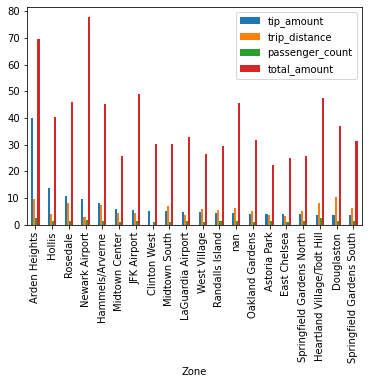

In [95]:
# Groupby PULocationID - using only top 20 values due to large number (265) of PULocations
# mean values show that 'Arden Heights' has highest tip_amount but 'Newark Airport' has  highest total_amount
# Lot of airports in top 20 PULocations indicating longer trips with higher fare and tips
puloc = tripdata.loc[:,['tip_amount','trip_distance','passenger_count', 'total_amount', 'PULocationID']].groupby(['PULocationID']).mean().sort_values(['tip_amount'],ascending=False)[:20]
locidzone = pd.merge(pd.DataFrame(list(puloc.index),columns=['LocationID']),loc_zone[['LocationID','Zone']],how='inner',on='LocationID')
puloc['LocationID'] = puloc.index
puloc.reset_index(drop=True,inplace=True)
puloczone = pd.merge(puloc,locidzone,how='inner',on='LocationID')
puloczone.index = puloczone['Zone']
puloczone.drop(['LocationID','Zone'],axis=1,inplace=True)
puloczone.plot(kind='bar').legend(loc='upper right')

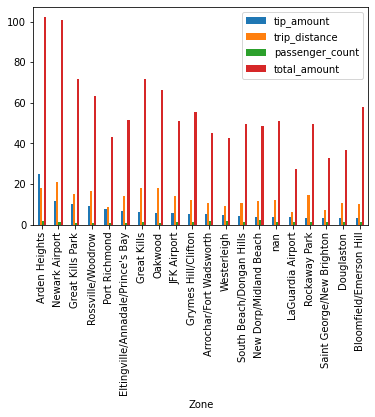

In [96]:
# Groupby DOLocationID - using only top 20 values due to large number (265) of DOLocations
# mean values show that 'Arden Heights' and 'Newark Airport' have highest tip_amount and total_amount
# Lot of airports in top 20 DOLocations indicating longer trips with higher fare and tips
doloc = tripdata.loc[:,['tip_amount','trip_distance','passenger_count', 'total_amount', 'DOLocationID']].groupby(['DOLocationID']).mean().sort_values(['tip_amount'],ascending=False)[:20]
locidzone = pd.merge(pd.DataFrame(list(doloc.index),columns=['LocationID']),loc_zone[['LocationID','Zone']],how='inner',on='LocationID')
doloc['LocationID'] = doloc.index
doloc.reset_index(drop=True,inplace=True)
doloczone = pd.merge(doloc,locidzone,how='inner',on='LocationID')
doloczone.index = doloczone['Zone']
doloczone.drop(['LocationID','Zone'],axis=1,inplace=True)
doloczone.plot(kind='bar').legend(loc='upper right')

In [97]:
# 5. Option 1 - Find an anomaly in the data and explain your findings

# I am going to explain this first before building the model (4) as it is an important input to the model

In [98]:
# As we want to build a model to predict tip_amount (target output variable y), we need data to train the model
# However, tip_amount data is an unbalanced dataset as 60% of the values are 0 
tip0_data = tripdata[tripdata['tip_amount'] == 0]
tipN0_data = tripdata[tripdata['tip_amount'] != 0]
print('No Tip: %.2f, Tip: %.2f' %((len(tip0_data)/len(tripdata)),(len(tipN0_data)/len(tripdata))))

No Tip: 0.60, Tip: 0.40


In [99]:
# Training the model on this will give bad results in real world testing
# Because model will overfit to all the 0's in tip_amount (target y) for different combinations of features
# We need synthetic data for tip_amount. For Eg: mean of all tips or % of total amount, to get a more realistic training dataset
# This is sensible as objective of the model is to predict tip_amount for a trip, irrespective of card or cash payment

In [100]:
# While tips can be 0 for paid trips, they are 0 for all cash payments (payment_type 2), which is 52% of the data
# This is most likely due to driver's having less time to enter tip amount separately or not at all
tip_pmttype = tripdata[tripdata['payment_type'] == 2][tripdata['tip_amount'] == 0]
print(tip_pmttype[['payment_type','total_amount', 'tip_amount']].head(20))
print('Cash payment tip=0: %.2f'%(len(tip_pmttype)/len(tripdata)))

    payment_type  total_amount  tip_amount
0              2          12.3         0.0
3              2           7.8         0.0
8              2           8.3         0.0
10             2          23.8         0.0
12             2           7.3         0.0
13             2           7.3         0.0
16             2           4.8         0.0
27             2           9.8         0.0
28             2          18.3         0.0
33             2           8.8         0.0
39             2           6.3         0.0
40             2          11.8         0.0
44             2           7.3         0.0
45             2           7.8         0.0
46             2          19.8         0.0
48             2           7.3         0.0
49             2           5.8         0.0
52             2           9.8         0.0
53             2           6.3         0.0
54             2           6.8         0.0
Cash payment tip=0: 0.52


In [101]:
# So for now we can assume that there will be some tip amount depending on the trip
# Using mean of all tips is not a good option as its affected by total number of trips, including 0 tip trips
# It would result in a bad model fit as target variable y will have same value for different combinations of features
print(tripdata['tip_amount'].mean())
print(tipN0_data['tip_amount'].mean())

1.1287872317134355
2.8000509021346796


In [102]:
# Better way would be to use 15% of total_amount as tip_amount, as that is what people normally do and used for card payments too
tripdata.loc[tripdata['tip_amount'] == 0, 'tip_amount'] = tripdata['total_amount']*0.15
# Now tip_amount is 0 only when total_amount is 0
print(tripdata.loc[tripdata['tip_amount'] == 0, ['total_amount','tip_amount']].sum())

total_amount    0.0
tip_amount      0.0
dtype: float64


In [103]:
# We can always test the model with original 0 values in tip_amount
# Now we have the data ready for training and testing the model

In [104]:
# 4. Build a model for taxi drivers to predict which type of trips yield most tips

In [105]:
# This is a regression problem as we are predicting real number values ($ tip_amount) with a wide range
# Two algorithms have been considered - RandomForest and XGBoost, as they generally give best results compared to others

In [106]:
# We can use pipeline and gridsearchcv libraries to train/test/tune multiple models at the same time - code given at the end
    # But given the data size, it takes long and local machine crashes, despite using only a few hyperparameters
# A simple Deep Learning model was also tested but the results were not good so not being used - code given at the end
    # Also, we can't explain the model fully due to no feature importance property

In [107]:
# Drop 'fare_amount' as it is highly correlated with 'total_amount', being its component. (See 2. EDA correlation heatmap)
# If we keep it the model overfits to amount features and misses out on using other relevant features
tripdata.drop(['fare_amount'], axis=1, inplace=True)

In [108]:
# Split the data into target y and independent X features
y = tripdata.loc[:, 'tip_amount'].values
tripdata.drop(['tip_amount'], axis=1, inplace=True)
X = tripdata.iloc[:, :].values

In [109]:
# Split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [110]:
# Build the regression model 
# model = RandomForestRegressor(n_estimators=500, n_jobs=-1)
model = XGBRegressor(learning_rate=0.3)

In [111]:
print('Start time: ', datetime.datetime.now())
# Fit the model to the training data
model.fit(X_train, y_train)

# Using the model predict y values using the X_test data 
y_pred = model.predict(X_test)

print('End time: ', datetime.datetime.now())

Start time:  2022-06-19 20:45:08.276577
End time:  2022-06-19 20:45:37.077001


In [112]:
# Calculate error metrics for predicted y values vs y test data
mse = mean_squared_error(y_test , y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test , y_pred)
r2 = r2_score(y_test , y_pred)
print('MSE:%.4f, RMSE:%.4f, MAE:%.4f, R2:%.4f' %(mse, rmse, mae, r2))

MSE:0.4981, RMSE:0.7058, MAE:0.1931, R2:0.8979


In [ ]:
# Results analysis - XGBoost and RandomForest, with/without 'fare_amount'

In [ ]:
# 1.a. XGBoost - without 'fare_amount'
# MSE:0.4981, RMSE:0.7058, MAE:0.1931, R2:0.8979
# Feature importance main - total_amount, RatecodeID, trip_distance, duration_mins, tolls_amount, payment_type, day
# Does not overfit to total_amount(.5)
# PULocationID and DOLocationID are much lower in importance, so PU/DO locations are not as important 

<AxesSubplot:>

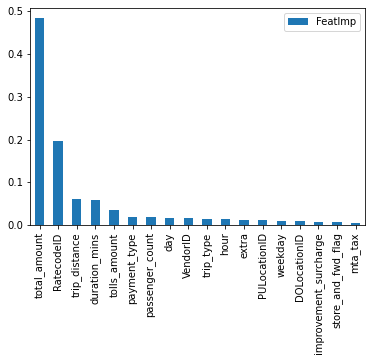

In [113]:
#Plot the Feature Importance
featimp = pd.DataFrame(model.feature_importances_)
featimp = featimp.rename({0:'FeatImp'}, axis='columns')
featimp.index = tripdata.columns
featimp = featimp.sort_values(by=['FeatImp'], ascending=False)
featimp.plot(kind='bar')

<AxesSubplot:>

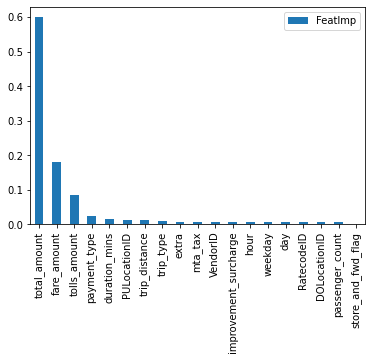

In [50]:
# 1.b. XGBoost - with 'fare_amount'
# This result is stored, cannot be got on run as it requires commenting tripdata.drop(['fare_amount']
# MSE:0.1817, RMSE:0.4263, MAE:0.1211, R2:0.9617
# Feature importance main - total_amount, tolls_amount, payment_type
# Overfits to total_amount(.6) and fare_amount(.2) and rest almost 0

Start time:  2022-06-19 20:50:12.539431
End time:  2022-06-19 21:00:28.819996
MSE:0.4813, RMSE:0.6938, MAE:0.1018, R2:0.9013


<AxesSubplot:>

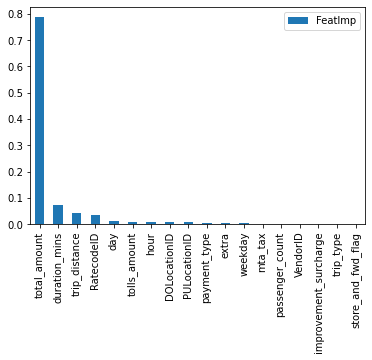

In [115]:
# 2.a. RandomForest - without 'fare_amount'
# This result is stored, cannot be got on run as it requires running model code again with RandomForestRegressor 
# MSE:0.4813, RMSE:0.6938, MAE:0.1018, R2:0.9013
# Feature importance main - total_amount, duration_mins, trip_distance, RatecodeID
# Overfits to total_amount(.77) and rest too small

Start time:  2022-06-19 20:20:03.037530
End time:  2022-06-19 20:34:41.187523
MSE:0.1007, RMSE:0.3174, MAE:0.0262, R2:0.9788


<AxesSubplot:>

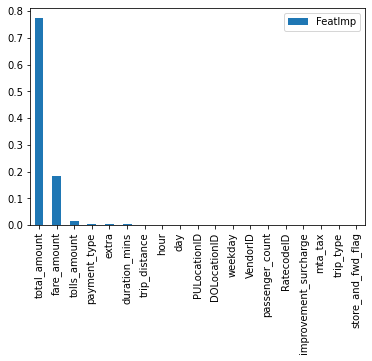

In [51]:
# 2.b. RandomForest - with 'fare_amount'
# This result is stored, cannot be got on run as it requires commenting tripdata.drop(['fare_amount']
# MSE:0.1007, RMSE:0.3174, MAE:0.0262, R2:0.9788
# Feature importance main - total_amount, fare_amount, tolls_amount, payment_type
# Overfits to total_amount(.77) and fare_amount(.18) and rest almost 0

In [57]:
# Final suggestions based on model

In [58]:
# While RandomForest gives better metrics it overfits to one feature - 'total_amount'
# XGBoost with slightly worse metrics fits better to more features
# Comparing feature importance for both algorithms with EDA, XGBoost fits to more relevant features. Hence preferred
# Dropping 'fare_amount' before building the model is required as it is causing overfitting with 'total_amount'
    #  Being highly correlated. Also, it prevents the model from learning about other features importance   

# Based on XGBoost feature importance, to get most tips drivers should consider:
    # total_amount - higher trip fare will result in higher tips
    # RatecodeID - While Ratecode is more relevant than PU/DO location, it still points to airport or affluent locations
    # duration_mins, trip_distance - both indicate longer trip resulting in higher tips
    # payment_type - is relevant and possibly 'card' resulting in higher tips, as its easy to add to fare
    # day - also relevant, as some days might result in higher tips. Requires further analysis
    # tolls_amount - is looking relevant as correlation is low with total_amount. Requires further analysis
# A combination of above features probably results in highest tips

# My suggestion would be to train XGBoost model with different month/year datasets, compare with real world test results
    # We can also test the model with original 0 values in tip_amount, instead of synthetic values
# Depending on results, remove non-significant features and with/without tip_amount synthetic data, re-train/re-test and check results again
# Once results stabilize and are acceptable, deploy final model with best feature set

# Building a model is an iterative process so its better to try a few variations in algorithms/datasets before choosing best model

In [59]:
#### This pipeline and gridsearchcv code takes long to run, so commented out ####

In [60]:
# Create pipeline to run gridsearchcv for best estimator and hyperparameters
# pipe_rf = Pipeline([('rgr', RandomForestRegressor())])
# pipe_xgb = Pipeline([('rgr', XGBRegressor())])

# # Set grid search params
# grid_params_rf = [{'rgr__n_estimators' : [200,500],
#                    'rgr__max_features' : ['sqrt', 'log2']}]

# grid_params_xgb = [{'rgr__objective' : ['reg:squarederror'],
#                     'rgr__learning_rate' : [0.3,0.5]}]

# # Create the grid search objects
# gs_rf = GridSearchCV(estimator=pipe_rf,
#                      param_grid=grid_params_rf,
#                      scoring='neg_mean_squared_error',
#                      cv=10,
#                      n_jobs=-1)

# gs_xgb = GridSearchCV(estimator=pipe_xgb,
#                       param_grid=grid_params_xgb,
#                       scoring='neg_mean_squared_error',
#                       cv=10,
#                       n_jobs=-1)

# # List of grid pipelines
# grids = [gs_rf, gs_xgb] 
# # Grid dictionary for pipeline/estimator
# grid_dict = {0:'RandomForestRegressor', 1: 'XGBoostRegressor'}

# # Fit the pipeline of estimators using gridsearchcv
# print('Fitting the gridsearchcv to pipeline of estimators...')
# resulterrorgrid = {}

# for gsid,gs in enumerate(grids):
#     print('\nEstimator: %s. Start time: %s' %(grid_dict[gsid], datetime.datetime.now()))
#     gs.fit(X_train, y_train)
#     print('\n Best score : %.5f' % gs.best_score_)
#     print('\n Best grid params: %s' % gs.best_params_)
#     y_pred = gs.predict(X_test)
#     mse = mean_squared_error(y_test , y_pred)
#     rmse = np.sqrt(mse)
#     mae = mean_absolute_error(y_test , y_pred)
#     r2 = r2_score(y_test , y_pred)
#     resulterrorgrid[grid_dict[gsid]+'_best_params'] = gs.best_params_
#     resulterrorgrid[grid_dict[gsid]+'_best_score'] = gs.best_score_
#     resulterrorgrid[grid_dict[gsid]+'_mse'] = mse
#     resulterrorgrid[grid_dict[gsid]+'_rmse'] = rmse
#     resulterrorgrid[grid_dict[gsid]+'_mae'] = mae
#     resulterrorgrid[grid_dict[gsid]+'_r2'] = r2

# print('\n', resulterrorgrid)


In [61]:
#### Code for Deep Learning model, not used ####
# import tensorflow as tf
# neurons = 200

# annmodel = tf.keras.models.Sequential()
# annmodel.add(tf.keras.layers.Dense(neurons, activation='relu'))
# annmodel.add(tf.keras.layers.Dense(neurons, activation='relu'))
# annmodel.add(tf.keras.layers.Dense(neurons, activation='relu'))
# annmodel.add(tf.keras.layers.Dense(1, activation='relu'))

# annmodel.compile(loss=tf.keras.losses.MeanSquaredError(),
#               optimizer=tf.keras.optimizers.Adam(),
#               metrics=[tf.keras.metrics.RootMeanSquaredError()])

# history = annmodel.fit(X_train, y_train, epochs=20)

# # Plot the train/test accuracy to see marginal improvement
# plt.plot(history.history['root_mean_squared_error'], label='root_mean_squared_error')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend(loc='lower right')
# plt.title('ANN Train Vs Test')
# plt.show()

# y_pred = annmodel.predict(X_test, verbose=1)

# # Accuracy metrics
# mse = mean_squared_error(y_test , y_pred)
# rmse = np.sqrt(mse)
# mae = mean_absolute_error(y_test , y_pred)
# r2 = r2_score(y_test , y_pred)
# print('ANN Metrics- MSE:%.4f, RMSE:%.4f, MAE:%.4f, R2:%.4f' %(mse, rmse, mae, r2))